# Continual learning for SGP demo
Here we demonstrate the use of performance of continual learning for sparse Gaussian processes on the banana classification dataset, available at https://www.kaggle.com/saranchandar/standard-classification-banana-dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pvi.models.sgp.sgp import SparseGaussianProcessClassification
from pvi.distributions.gp_distributions import \
    MultivariateGaussianDistributionWithZ, MultivariateGaussianFactorWithZ
#Not actually defined try instead
#from pvi.clients.streaming_sgp_client import StreamingSGPClient
from pvi.clients.continual_learning_sgp import ContinualLearningSGPClient
from pvi.servers.continual_learning_server import ContinualLearningServer

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
import gpytorch

from torch import nn
from gpytorch.kernels import ScaleKernel, RBFKernel


%matplotlib inline
torch.set_default_dtype(torch.float64)

### Set up data and helper functions

In [20]:
# Definitions of the different types of plots
def plot_data(x, y, ax=None):
    x1_min, x1_max = -3.5, 3.
    x2_min, x2_max = -3., 3.5
    
    x1x1, x2x2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), 
                             np.linspace(x2_min, x2_max, 100))
    
    if ax is None:
        plt.figure(figsize=(8, 6), dpi=200)
        plt.xlim(x1x1.min(), x1x1.max())
        plt.ylim(x2x2.min(), x2x2.max())
        ax = plt.gca()
    
    ax.plot(x[y == 0, 0], x[y == 0, 1], "o", color="C1", label="Class 1", alpha=.5)
    ax.plot(x[y == 1, 0], x[y == 1, 1], "o", color="C0", label="Class 2", alpha=.5)
    
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc="upper left", scatterpoints=1, numpoints=1)
    
    return x1x1, x2x2

def plot_predictive_distribution(x, y, z, model, q, ax=None, x_old=None, y_old=None, z_old=None):
    x1x1, x2x2 = plot_data(x, y, ax)
    
    if ax is None:
        ax = plt.gca()
    
    x_predict = np.concatenate((x1x1.ravel().reshape(-1, 1), 
                                x2x2.ravel().reshape(-1, 1)), 1)
    
    y_predict = model(torch.tensor(x_predict), q=q, diag=True)
    y_predict = y_predict.mean.detach().numpy().reshape(x1x1.shape)
    
    cs2 = ax.contour(x1x1, x2x2, y_predict, colors=["k"],  levels=[0.2, 0.5, 0.8])#linewidth=2,
    ax.clabel(cs2, fmt="%2.1f", colors="k", fontsize=14)
        
    ax.scatter(z[:, 0], z[:, 1], color="r", marker="s")
    
    if x_old is not None:
        ax.plot(x_old[y_old == 0, 0], x_old[y_old == 0, 1], "o", color="C1", label="Class 1", alpha=.1)
        ax.plot(x_old[y_old == 1, 0], x_old[y_old == 1, 1], "o", color="C0", label="Class 2", alpha=.1)
        ax.scatter(z_old[:, 0], z_old[:, 1], color="r", marker="o")        
        
def plot_bayesian_predictive_distribution(x, y, z, model, q, qeps, ax=None, x_old=None, y_old=None, z_old=None, neps=10):
    x1x1, x2x2 = plot_data(x, y, ax)
    
    if ax is None:
        ax = plt.gca()
    
    x_predict = np.concatenate((x1x1.ravel().reshape(-1, 1), 
                                x2x2.ravel().reshape(-1, 1)), 1)
    
    preds = []
    for _ in range(neps):
        eps = qeps.sample()
        model.hyperparameters = eps
        pp = model(torch.tensor(x_predict), q, diag=True)
        preds.append(pp.mean.detach().numpy())
        
    y_predict = (sum(preds) / len(preds)).reshape(x1x1.shape)
    
    cs2 = ax.contour(x1x1, x2x2, y_predict, colors=["k"], lw=2, levels=[0.2, 0.5, 0.8])
    ax.clabel(cs2, fmt="%2.1f", colors="k", fontsize=14)
        
    ax.scatter(z[:, 0], z[:, 1], color="r", marker="s")
    
    if x_old is not None:
        ax.plot(x_old[y_old == 0, 0], x_old[y_old == 0, 1], "o", color="C1", label="Class 1", alpha=.1)
        ax.plot(x_old[y_old == 1, 0], x_old[y_old == 1, 1], "o", color="C0", label="Class 2", alpha=.1)
        ax.scatter(z_old[:, 0], z_old[:, 1], color="r", marker="o")
    

In [21]:
def load_data(name, train_proportion, data_base_dir):
    filename = os.path.join(data_base_dir, name, "banana.csv")
    data = np.loadtxt(filename, delimiter=",", skiprows=1)
    
    x = data[:, :2]
    y = data[:, -1]
    
    # Replace 1's with 0's and 2's with 1's.
    y[y == 1] = 0
    y[y == -1] = 1
    
    N = x.shape[0]
    N_train = int(np.ceil(train_proportion * N))
    
    x_train = x[0:N_train]
    y_train = y[0:N_train]
    x_test = x[N_train:]
    y_test = y[N_train:]

    training_set = {
        "x": x_train,
        "y": y_train,
    }

    test_set = {
        "x": x_test,
        "y": y_test
    }

    D = x_test.shape[1]

    return training_set, test_set, D

def generate_clients_data(x, y, M, client_size_factor, class_balance_factor, dataset_seed):
        # this function ought to return a list of (x, y) tuples.
        # you need to set the seed in the main experiment file to ensure that this function becomes deterministic

        random_state = np.random.get_state()

        if dataset_seed is not None:
            np.random.seed(dataset_seed)

        if M == 1:
            client_data = [{"x": x, "y": y}]
            N_is = [x.shape[0]]
            props_positive = [np.mean(y > 0)]

            return client_data, N_is, props_positive, M

        if M % 2 != 0: raise ValueError('Num clients should be even for nice maths')

        N = x.shape[0]
        small_client_size = int(np.floor((1 - client_size_factor) * N/M))
        big_client_size = int(np.floor((1 + client_size_factor) * N/M))

        class_balance = np.mean(y == 0)

        small_client_class_balance = class_balance + (1 - class_balance) * class_balance_factor
        small_client_negative_class_size = int(np.floor(small_client_size * small_client_class_balance))
        small_client_positive_class_size = int(small_client_size - small_client_negative_class_size)

        if small_client_negative_class_size < 0: raise ValueError('small_client_negative_class_size is negative, invalid settings.')
        if small_client_positive_class_size < 0: raise ValueError('small_client_positive_class_size is negative, invalid settings.')


        if small_client_negative_class_size * M/2 > class_balance * N:
            raise ValueError(f'Not enough negative class instances to fill the small clients. Client size factor:{client_size_factor}, class balance factor:{class_balance_factor}')

        if small_client_positive_class_size * M/2 > (1-class_balance) * N:
            raise ValueError(f'Not enough positive class instances to fill the small clients. Client size factor:{client_size_factor}, class balance factor:{class_balance_factor}')


        pos_inds = np.where(y > 0)
        zero_inds = np.where(y == 0)
        
        assert (len(pos_inds[0]) + len(zero_inds[0])) == len(y), "Some indeces missed."
        
        print(f'x shape {x.shape}')
        print(f'positive indices {pos_inds}')
        print(f'zero indices {zero_inds}')

        y_pos = y[pos_inds]
        y_neg = y[zero_inds]

        x_pos = x[pos_inds]
        x_neg = x[zero_inds]

        client_data = []

        # Populate small classes.
        for i in range(int(M/2)):
            client_x_pos = x_pos[:small_client_positive_class_size]
            x_pos = x_pos[small_client_positive_class_size:]
            client_y_pos = y_pos[:small_client_positive_class_size]
            y_pos = y_pos[small_client_positive_class_size:]

            client_x_neg = x_neg[:small_client_negative_class_size]
            x_neg = x_neg[small_client_negative_class_size:]
            client_y_neg = y_neg[:small_client_negative_class_size]
            y_neg = y_neg[small_client_negative_class_size:]

            client_x = np.concatenate([client_x_pos, client_x_neg])
            client_y = np.concatenate([client_y_pos, client_y_neg])

            shuffle_inds = np.random.permutation(client_x.shape[0])

            client_x = client_x[shuffle_inds, :]
            client_y = client_y[shuffle_inds]

            client_data.append({'x': client_x, 'y': client_y})

        # Recombine remaining data and shuffle.

        x = np.concatenate([x_pos, x_neg])
        y = np.concatenate([y_pos, y_neg])
        shuffle_inds = np.random.permutation(x.shape[0])

        x = x[shuffle_inds]
        y = y[shuffle_inds]

        # Distribute among large clients.
        for i in range(int(M/2)):
            client_x = x[:big_client_size]
            client_y = y[:big_client_size]

            x = x[big_client_size:]
            y = y[big_client_size:]

            client_data.append({'x': client_x, 'y': client_y})

        N_is = [data['x'].shape[0] for data in client_data]
        props_positive = [np.mean(data['y'] > 0) for data in client_data]

        np.random.set_state(random_state)

        print(f'N_is {N_is}')
        print(f'Props positive: {props_positive}')

        return client_data, N_is, props_positive, M

In [22]:
name = "banana"
data_base_dir = "/Users/terjemildner/Desktop/PVI-main/data"
train_proportion = 0.8

training_set, test_set, D = load_data(
    name, train_proportion, data_base_dir)

In [23]:
M = 4

clients_data, nis, prop_positive, M = generate_clients_data(
    training_set["x"], 
    training_set["y"],
    M=M,
    client_size_factor=0,
    class_balance_factor=0,
    dataset_seed=0,
)

x shape (4240, 2)
positive indices (array([   0,    2,    6, ..., 4235, 4236, 4239]),)
zero indices (array([   1,    3,    4, ..., 4233, 4237, 4238]),)
N_is [1060, 1060, 1060, 1060]
Props positive: [0.5547169811320755, 0.5547169811320755, 0.5518867924528302, 0.5556603773584906]


### Set up clients

In [24]:
clients = []
num_inducing = 10

# Shared across all clients.
hyperparameters = {
    "D": D,
    "num_inducing": num_inducing,
    "kernel_class": RBFKernel,
    "kernel_params": {"lengthscale": .5},
    "optimiser": "Adam",
    "optimiser_params": {"lr": 5e-3},
    "epochs": 50,
    "batch_size": 100,
    "num_elbo_samples": 100,
    "num_predictive_samples": 100,
}

prior_nat_params = {
    "np1": torch.zeros(hyperparameters["num_inducing"]),
    "np2": -0.5 * torch.ones(hyperparameters["num_inducing"]).diag_embed(),
}

# Construct clients.
for i in range(M):
    model_i = SparseGaussianProcessClassification(hyperparameters=hyperparameters)
    data_i = clients_data[i]
    
    # Convert to torch.tensor.
    for k, v in data_i.items():
        data_i[k] = torch.tensor(v)
    
    # Randomly initialise private inducing points.
    perm = torch.randperm(len(data_i["x"]))
    idx = perm[:hyperparameters["num_inducing"]]
    z_i = data_i["x"][idx].clone()
    
    #StreamingSGPClient not defined, so try instead: ContinualLearningSGPClient
    #clients.append(StreamingSGPClient(data=data_i, model=model_i, inducing_locations=z_i))
    clients.append(ContinualLearningSGPClient(data=data_i, model=model_i, inducing_locations=z_i))

{'ard_num_dims': None, 'outputscale': 1.0, 'lengthscale': 1.0}
{'ard_num_dims': None, 'outputscale': 1.0, 'lengthscale': 1.0}
{'ard_num_dims': None, 'outputscale': 1.0, 'lengthscale': 1.0}
{'ard_num_dims': None, 'outputscale': 1.0, 'lengthscale': 1.0}


### Set up global model, approximate posterior and server.

In [25]:
# Construct global model and server.
model = SparseGaussianProcessClassification(hyperparameters=hyperparameters)

q = MultivariateGaussianDistributionWithZ(
    inducing_locations=None,
    nat_params=prior_nat_params, 
    is_trainable=False
)

server = ContinualLearningServer(
    model=model, 
    #previous shows 'q=q'? but base.__init__() shows args as self, models, p, clients
    p=q, 
    clients=clients,
    #hyperparameters={
    #    "max_iterations": len(clients),
    #}
)

{'ard_num_dims': None, 'outputscale': 1.0, 'lengthscale': 1.0}


### Run continual learning for SGP!

In [26]:
while not server.should_stop():
    server.tick()

    # Obtain predictions.
    pp = server.model_predict(torch.tensor(test_set["x"]))
    preds = pp.mean.detach().numpy()
    test_acc = np.sum(
        np.abs(2 * (preds > 0.5) - 1 + test_set["y"]) > 0) / np.size(test_set["y"])

    print(test_acc)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

0.9283018867924528


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

0.9198113207547169


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

0.9226415094339623


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

0.9216981132075471


In [27]:
def plot_training(training_array, ax=None):
    x_vals = np.arange(1, len(training_array)+1)
    
    if ax is None:
        plt.figure()
        ax = plt.gca()
        
    ax.grid(visible=True)
    ax.plot(x_vals, training_array)
    ax.set_xlabel('Step')
    
    if ax is None:
        plt.show()

In [28]:
print(server.log)
logs = server.get_compiled_log()
print("========================")
print(logs)

defaultdict(<class 'list'>, {'communications': [0], 'updated_client_times': [{'time': 0.050482988357543945, 'perf_counter': 0.05048158304998651, 'process_time': 0.09769499999999987, 0: {'time': 0.050347089767456055, 'perf_counter': 0.05034791701473296, 'process_time': 0.09757399999999983}}, {'time': 0.10345983505249023, 'perf_counter': 0.10346016602125019, 'process_time': 0.21996099999999785, 1: {'time': 0.040306806564331055, 'perf_counter': 0.04030683299060911, 'process_time': 0.08056299999999972}}, {'time': 0.1575305461883545, 'perf_counter': 0.15753104101167992, 'process_time': 0.3441169999999989, 2: {'time': 0.04135608673095703, 'perf_counter': 0.04135716694872826, 'process_time': 0.08330899999999986}}, {'time': 0.2134089469909668, 'perf_counter': 0.21341012499760836, 'process_time': 0.4691729999999996, 3: {'time': 0.041877031326293945, 'perf_counter': 0.04187829198781401, 'process_time': 0.08208899999999986}}], 'q': [MultivariateGaussianDistributionWithZ(), MultivariateGaussianDis

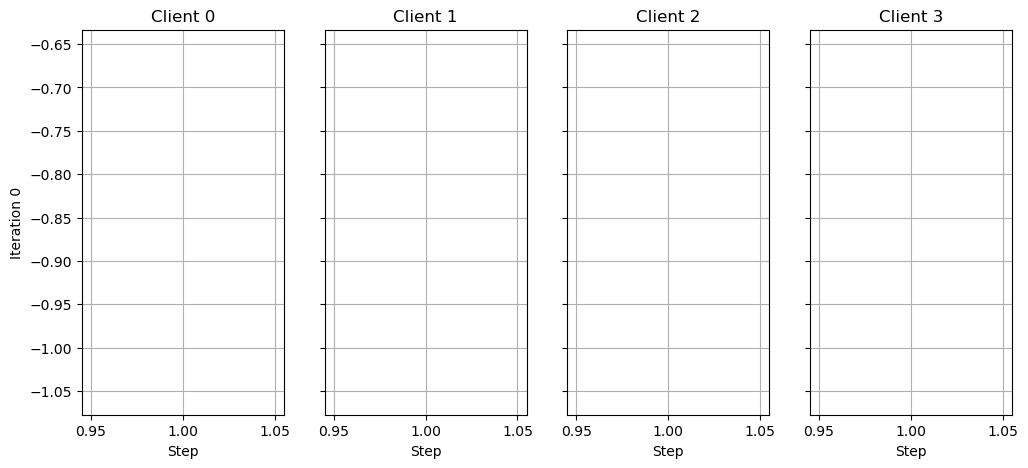

In [29]:
ncols = len(clients)
nrows = 1

fig, axes = plt.subplots(figsize=(ncols*3, nrows*5), nrows=nrows, ncols=ncols, sharey="row")


for i, client in enumerate(server.clients):

    if nrows > 1:
        for j in range(nrows):
            ax = axes[j, i]
            print(logs[f"client_{i}"])
            plot_training(logs[f"client_{i}"]["training_curves"][j]["elbo"], ax)

        axes[0, i].set_title("Client {}".format(i))
    else:
        ax = axes[i]
        plot_training(logs[f"client_{i}"]["training_curves"][0]["elbo"], ax)
        ax.set_title("Client {}".format(i))
    
if nrows > 1:
    for j in range(nrows):
        axes[j, 0].set_ylabel("Iteration {}".format(j))
else:
    axes[0].set_ylabel("Iteration {}".format(0))
        
        
plt.show()

[MultivariateGaussianDistributionWithZ(), MultivariateGaussianDistributionWithZ(), MultivariateGaussianDistributionWithZ(), MultivariateGaussianDistributionWithZ()]


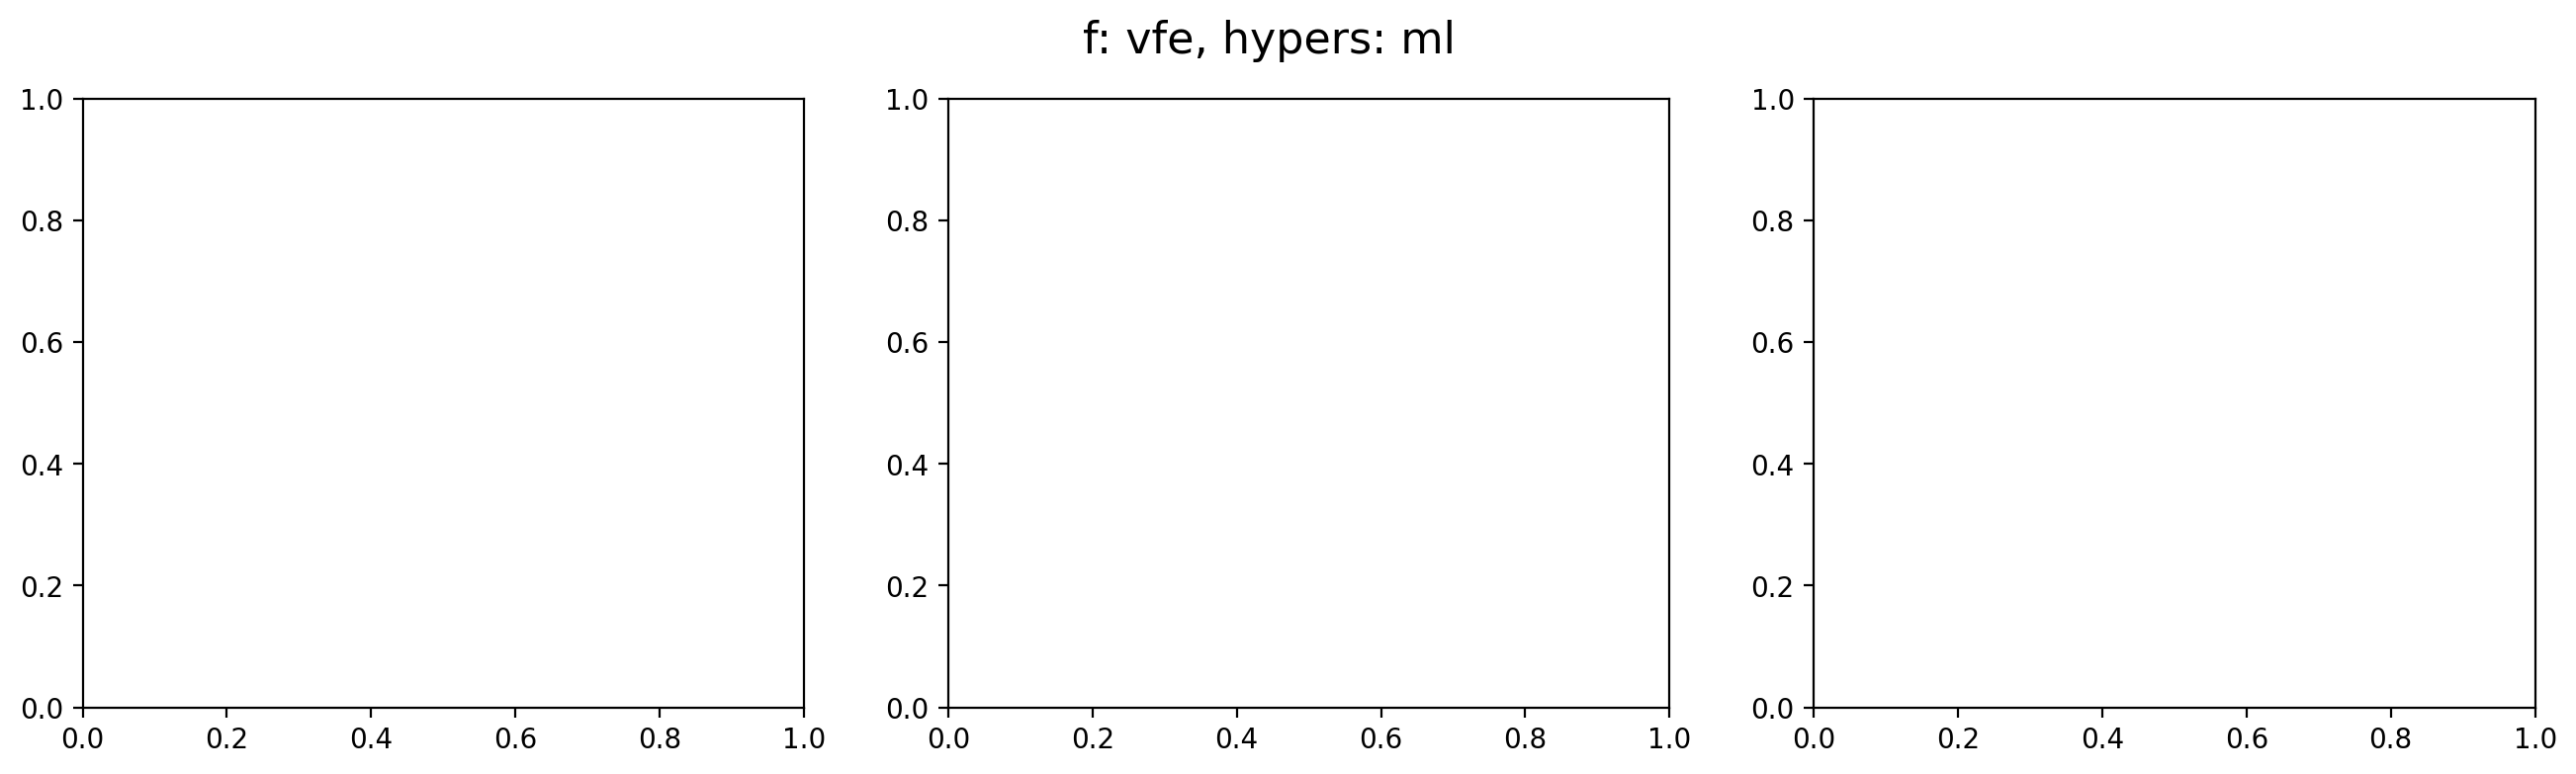

In [32]:
fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=3, dpi=200)

x_old, y_old, z_old = None, None, None

for q, model_state_dict, ax, client in zip(server.log["q"][0:], server.log["model_state_dict"][0:], axes, server.clients):
    x, y = client.data["x"].numpy(), client.data["y"].numpy()
    z = client.inducing_locations.numpy()
    model = copy.deepcopy(server.model)
    model.load_state_dict(model_state_dict)
    
    plot_predictive_distribution(x, y, z, model, q=q, ax=ax, x_old=x_old, y_old=y_old, z_old=z_old)
    
    if x_old is not None:
        x_old = np.concatenate((x_old, x), axis=0)
        y_old = np.concatenate((y_old, y), axis=0)
        z_old = np.concatenate((z_old, z), axis=0)
    else:
        x_old, y_old, z_old = x, y, z
    
plt.suptitle("f: vfe, hypers: ml", fontsize=16)
plt.show()